<a href="https://colab.research.google.com/github/dinaelmiari/Effect-of-Physiological-Parameters-on-PPG-Signal-based-Glucose-Estimation.ipynb/blob/main/Effect_of_Physiological_Parameters_on_PPG_Signal_based_Glucose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BACKGROUND**:

In this study, I used features extracted from three clean and high-quality PPG pulses, selected from a 15-second signal segment based on literature-supported criteria to ensure signal quality.

Instead of analyzing sliding windows or signal chunks, like in EEG or EMG studies that focus on rapid changes, I extracted meaningful features such as amplitude, width, area, and derivatives from these pulses. These features are known to reflect vascular properties indirectly related to glucose levels.

Since glucose changes occur gradually and PPG does not show fast, event-driven shifts, this feature-based approach from selected pulses was more appropriate and consistent with established research practices.

**Load Features Data from Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

file_path = '/content/drive/My Drive/Signal Processing project- EMMBIOME/Dataset_Green Light PPG.xlsx'


df = pd.read_excel(file_path)

# Check number of rows and columns
print("Shape (rows, columns):", df.shape)

# Show column names
print("Columns:", df.columns.tolist())

Mounted at /content/drive
Shape (rows, columns): (75, 45)
Columns: ['Name', 'Disease', 'Category', 'sysPeak', 'AI', 'DiaPeak', 'Dp_dist', 'delT', 'maximum', 'maximum1', 'maximum2', 'mean_PPG', 'mean_PPG1', 'mean_PPG2', 'minimum', 'minimum1', 'minimum2', 'P2P_Interval', 'PulseRate', 'RMS', 'root_mean_square1', 'root_mean_square2', 'SD', 'SD1', 'SD2', 'Signal_Energy', 'Signal_Energy1', 'Signal_Energy2', 'T_Interval', 'variance', 'variance1', 'variance2', 'ba_ratio', 'ca_ratio', 'da_ratio', 'ea_ratio', 'bcdea_ratio', 'bea_ratio', 'bcde_ratio', 'cdba_ratio', 'Age', 'Systolic BP', 'Diastolic BP', 'Hb', 'Glucose Level']


**Counting and Dropping NAN**

In [ ]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns #Dropping name of subjects

# Size of numerical data only
df_numerical = df[numerical_cols]
print("Shape before dropping NaNs:", df_numerical.shape)

Shape before dropping NaNs: (75, 42)


In [ ]:
# Count NaNs
print("Missing values per column:")
print(df_numerical.isna().sum())

print("Total missing values:", df_numerical.isna().sum().sum())

Missing values per column:
sysPeak              2
AI                   2
DiaPeak              2
Dp_dist              2
delT                 2
maximum              3
maximum1             2
maximum2             2
mean_PPG             2
mean_PPG1            2
mean_PPG2            2
minimum              2
minimum1             2
minimum2             2
P2P_Interval         2
PulseRate            2
RMS                  2
root_mean_square1    2
root_mean_square2    2
SD                   2
SD1                  2
SD2                  2
Signal_Energy        2
Signal_Energy1       2
Signal_Energy2       2
T_Interval           2
variance             2
variance1            2
variance2            2
ba_ratio             2
ca_ratio             2
da_ratio             2
ea_ratio             2
bcdea_ratio          2
bea_ratio            2
bcde_ratio           2
cdba_ratio           2
Age                  1
Systolic BP          1
Diastolic BP         1
Hb                   1
Glucose Level        1
dtype: 

In [ ]:
# Drop rows with NaNs in any numerical column
df_numerical_clean = df_numerical.dropna()

print("Shape after dropping NaNs:", df_numerical_clean.shape)
print("Any NaNs left?", df_numerical_clean.isna().any().any())


Shape after dropping NaNs: (72, 42)
Any NaNs left? False


**Feature Visualization**

Assessing underlying distribution of each feature

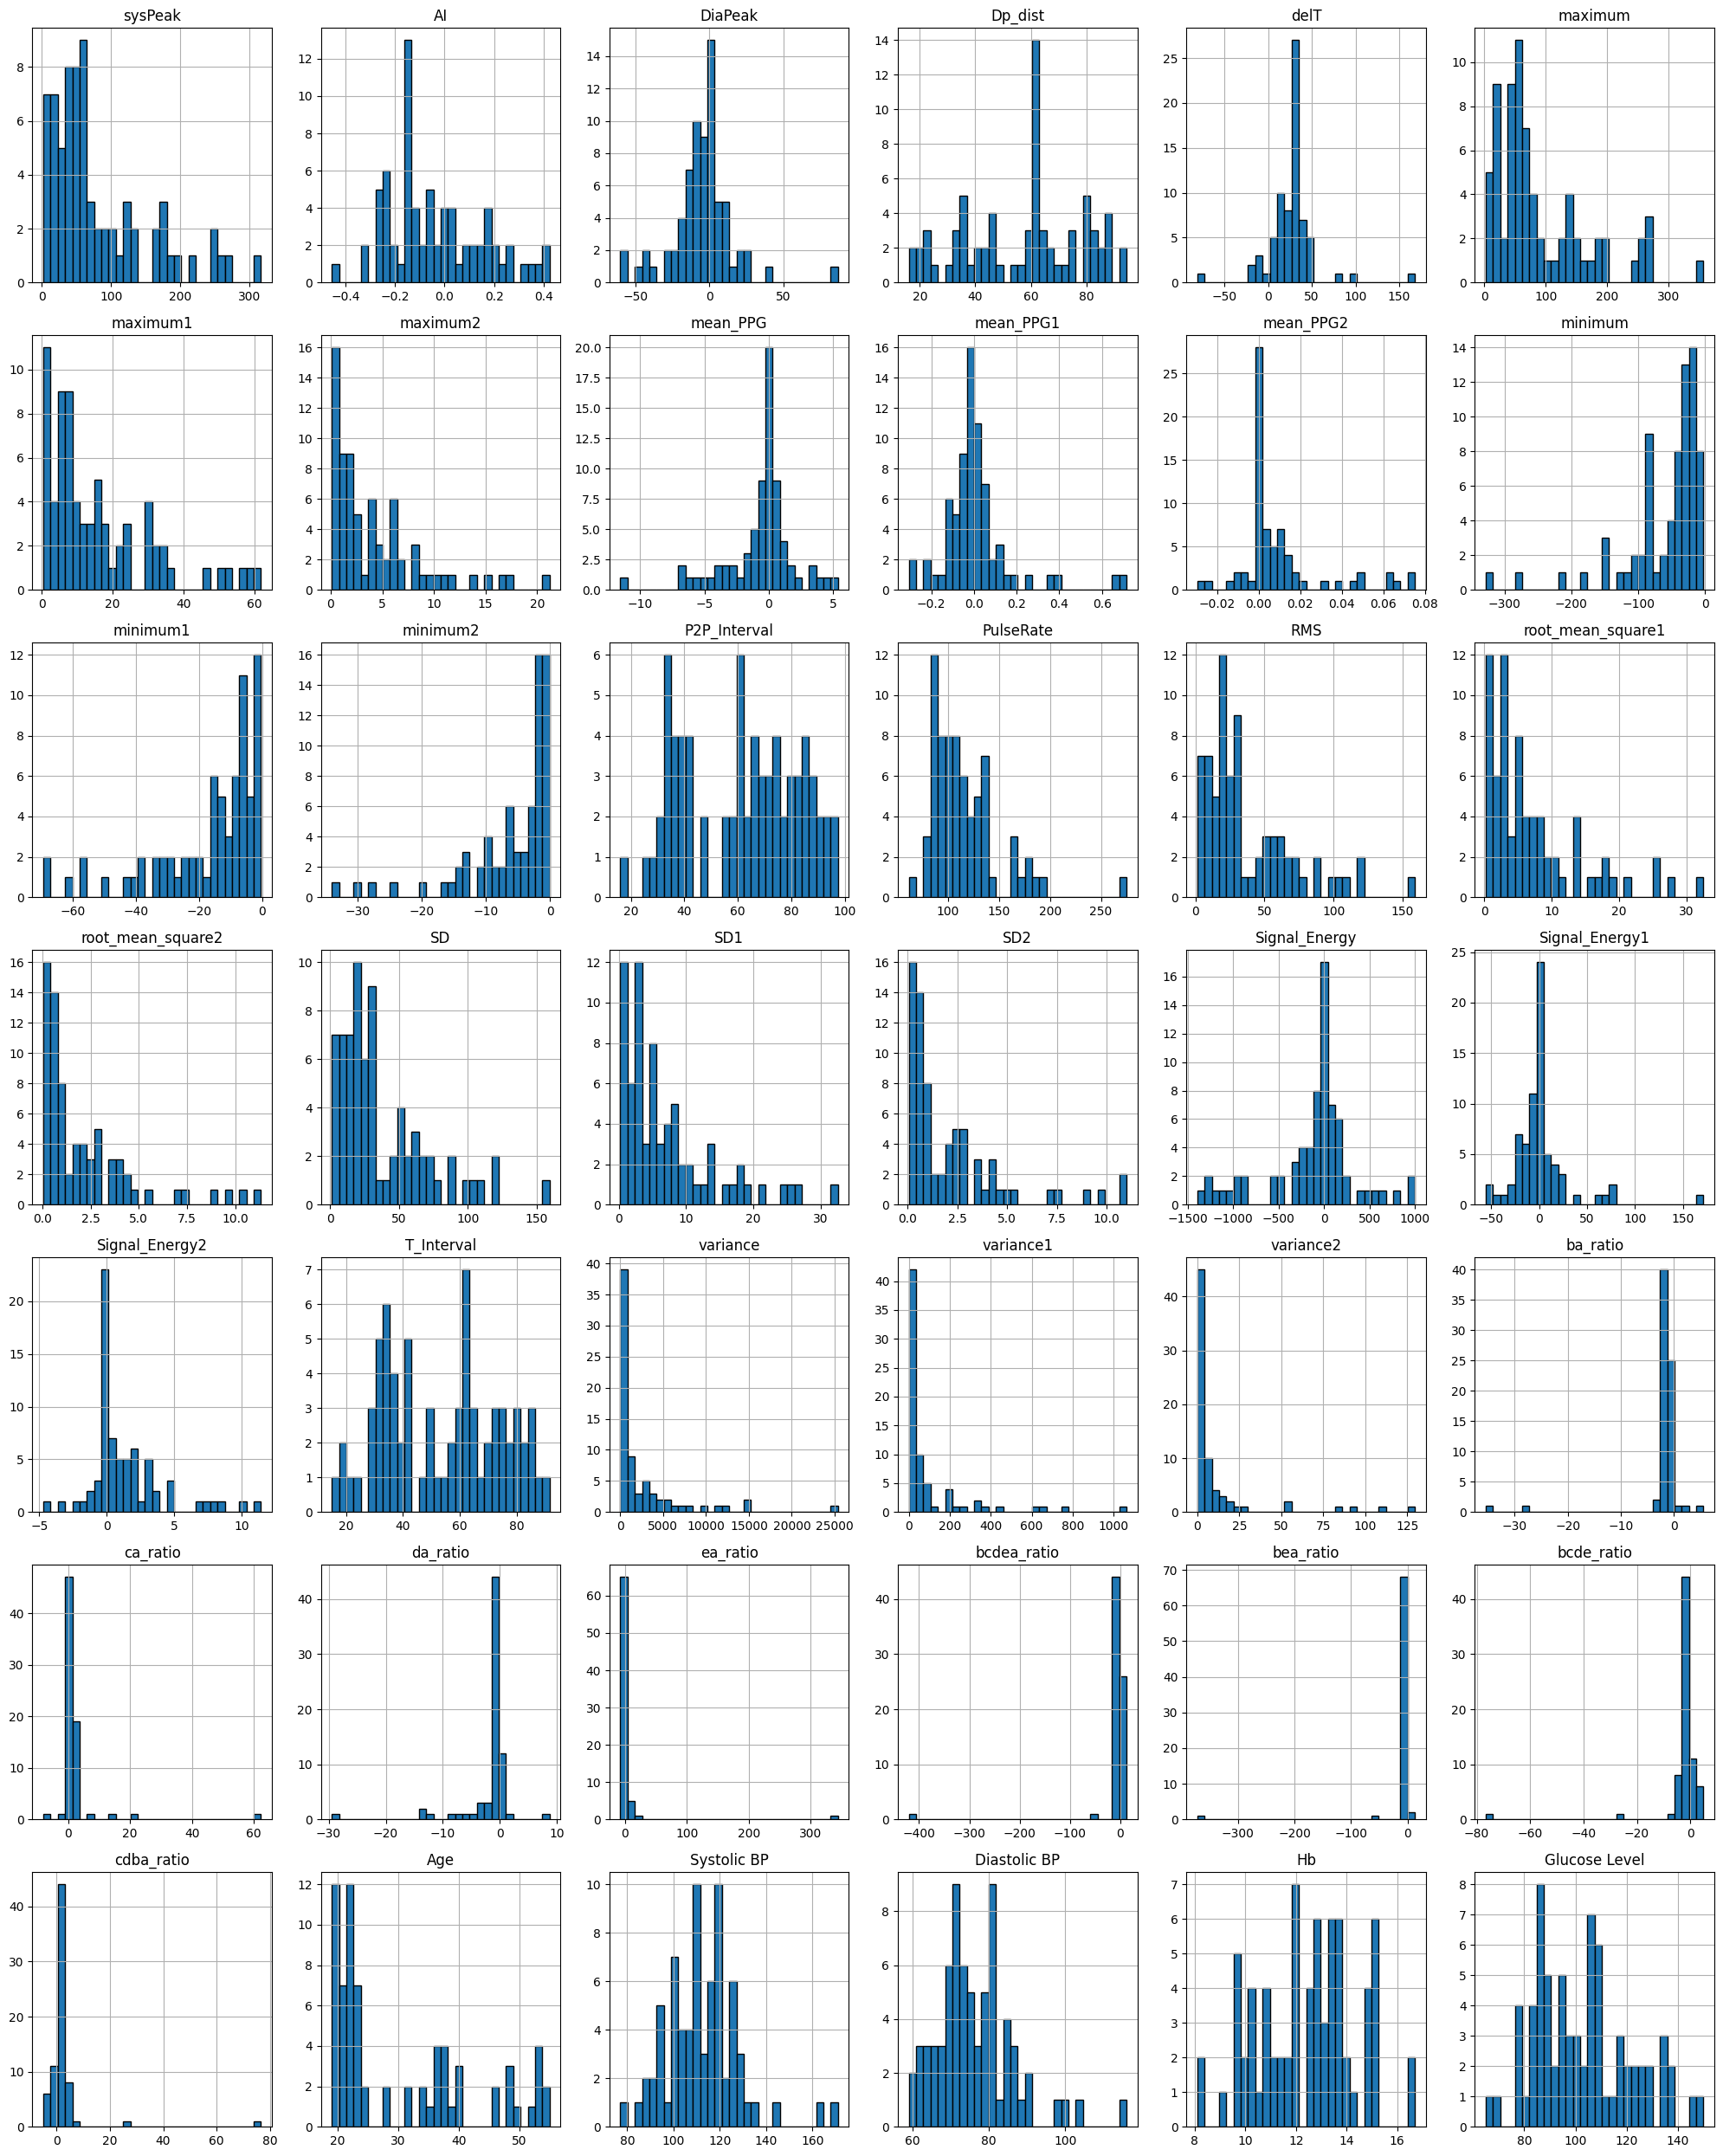

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot histograms for initial data exploration
plt.figure(figsize=(20, 25))  # Adjusted size for clarity

for i, col in enumerate(df_numerical_clean.columns, 1):
    plt.subplot(7, 6, i)  # 7 rows x 6 columns for 42 features
    df_numerical_clean[col].hist(bins=30, edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.show()

**Observation**

-Many features are right skewed, indicating that concentration is more towards lower values with few high valued outliers/unexpectedly high values due to pathological impact. (This behavior is common for variance like features)

-Some features are left skewed mainky the ratios.

-Few features show uniform distribution.


**Z Score Normalization of features**

-Differences in feature scales can negatively affect both correlation analysis and PCA, by distorting relationships between features and causing PCA to prioritize features with larger numerical ranges rather than truly informative patterns.

-Normalization is applied to make mean 0 and standard deviation 1 for all features.

-Z score normalization is chosen because it preserves the original feature distribution shape (unlike min-max scaling).



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

target_column = 'Glucose Level'

# Separate features from target and then features are normalized
features = df_numerical_clean.drop(columns=[target_column])
target = df_numerical_clean[target_column]

# Apply Z-score normalization
scaler = StandardScaler()
normalized_array = scaler.fit_transform(features)
normalized_features = pd.DataFrame(normalized_array, columns=features.columns)

# Reset index to avoid misalignment
normalized_features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

# Combine normalized features with target column
NORMALIZED_FEATURES = pd.concat([normalized_features, target], axis=1)

print("Z-score normalization complete and file saved as 'normalized_features.csv'")


Z-score normalization complete and file saved as 'normalized_features.csv'


**PPG Features Correlation with Physiological Parameters (BP, Glucose, Hb)**

-Correlation analysis was performed to evaluate individual correlations with the target variable.

-Highlight features that contribute more meaningfully to the prediction task.

**Spearman correlation** is used because it assesses monotonic relationships between PPG features and physiological targets (glucose, Hb, BP) without assuming linearity or normal distribution.

--This technique works by converting the values of each variable to ranks and computing pearson correlation on ranks.Hence, picking monotonic relationships.

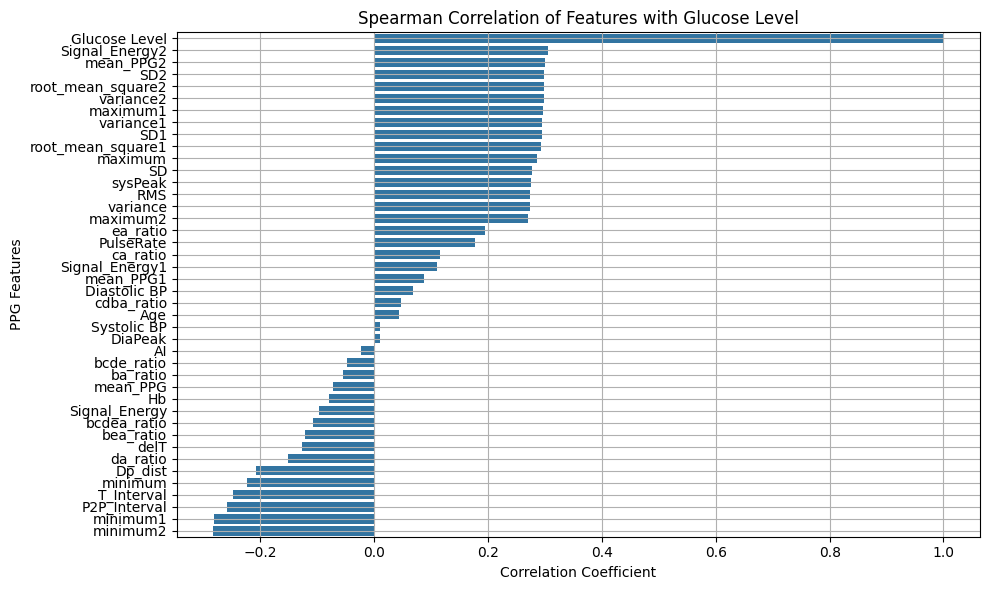

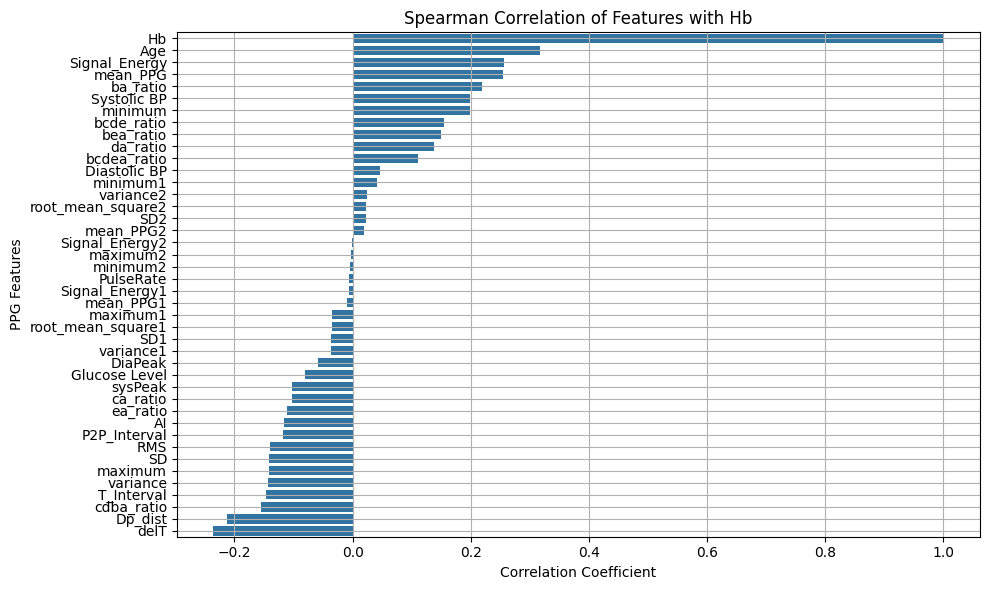

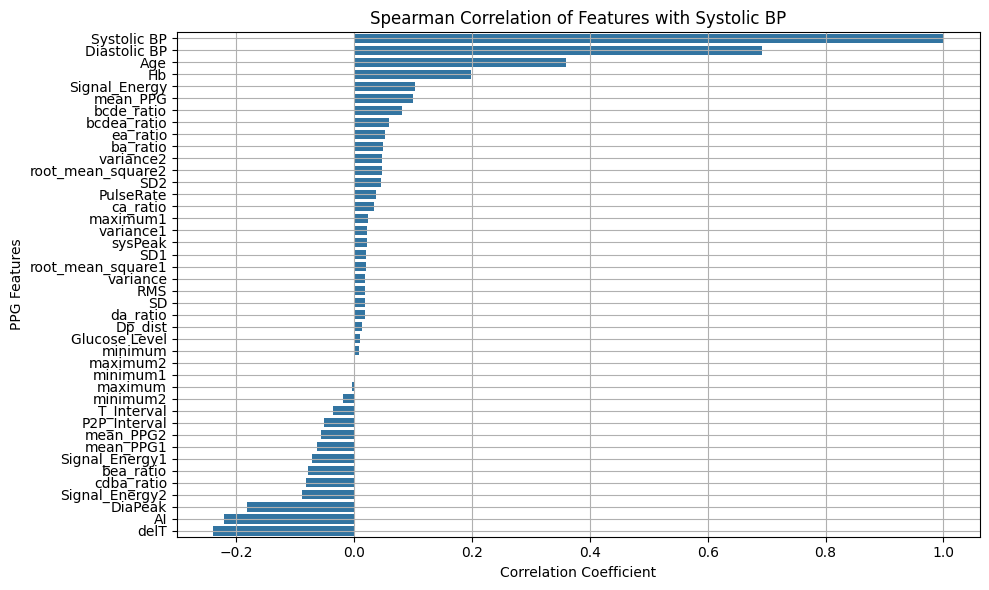

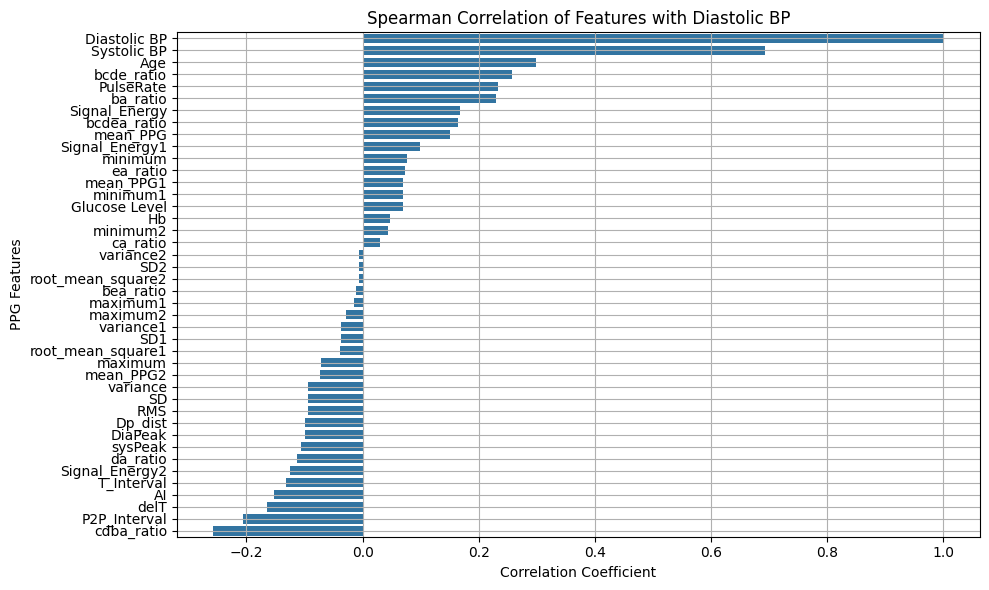

In [ ]:
import seaborn as sns

# List of target variables
targets = ['Glucose Level', 'Hb', 'Systolic BP', 'Diastolic BP']

# Dictionary to store correlations for each target
correlations = {}

# Loop through each target variable and compute correlation
for target in targets:
    if target in df_numerical_clean.columns:
        corr_data = df_numerical_clean.dropna(subset=[target])
        corr_spearman = corr_data.corr(method='spearman')[target].sort_values(ascending=False)

        correlations[target] = corr_spearman

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=corr_spearman.values, y=corr_spearman.index)
        plt.title(f"Spearman Correlation of Features with {target}")
        plt.xlabel("Correlation Coefficient")
        plt.ylabel("PPG Features")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


**Correlation Heatmap**

-To examine inter-feature relationships and identify highly correlated features, indicating redundancy.

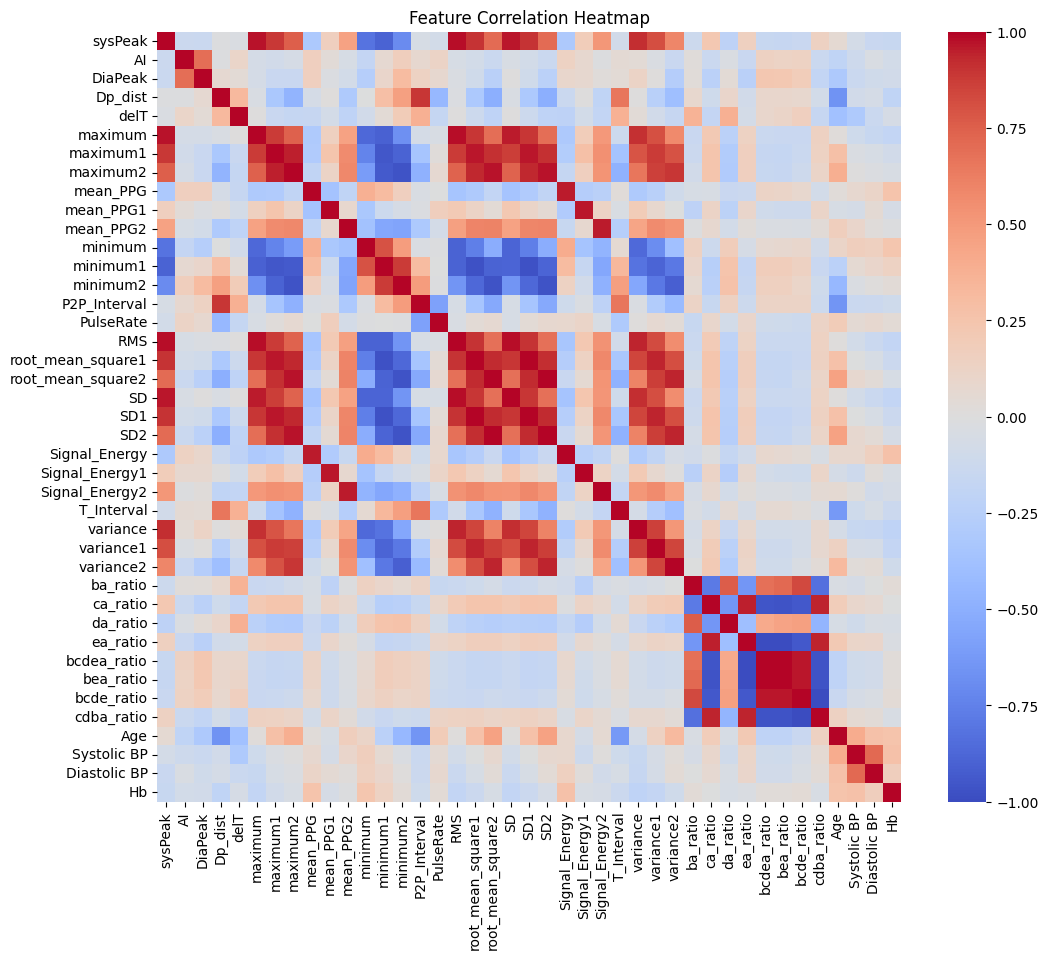

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = normalized_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


-The observed multi-collinearity suggested the dimensionality reduction to avoid redundancy and model complexity.

**Features Reduction and Selection**

**1. PCA on All (45) Normalized features**

-PCA was applied to transform the original set of 45 features into a smaller set of orthogonal (uncorrelated) principal component.

-Helps eliminate multicollinearity by ensuring the components are statistically independent.

PC1: 37.28% variance explained, Cumulative: 37.28%
PC2: 16.18% variance explained, Cumulative: 53.46%
PC3: 11.22% variance explained, Cumulative: 64.67%
PC4: 5.70% variance explained, Cumulative: 70.37%
PC5: 5.37% variance explained, Cumulative: 75.74%
PC6: 4.27% variance explained, Cumulative: 80.01%
PC7: 3.40% variance explained, Cumulative: 83.40%
PC8: 3.19% variance explained, Cumulative: 86.60%
PC9: 2.34% variance explained, Cumulative: 88.93%
PC10: 2.31% variance explained, Cumulative: 91.24%
PC11: 1.97% variance explained, Cumulative: 93.21%
PC12: 1.55% variance explained, Cumulative: 94.76%
PC13: 0.99% variance explained, Cumulative: 95.75%


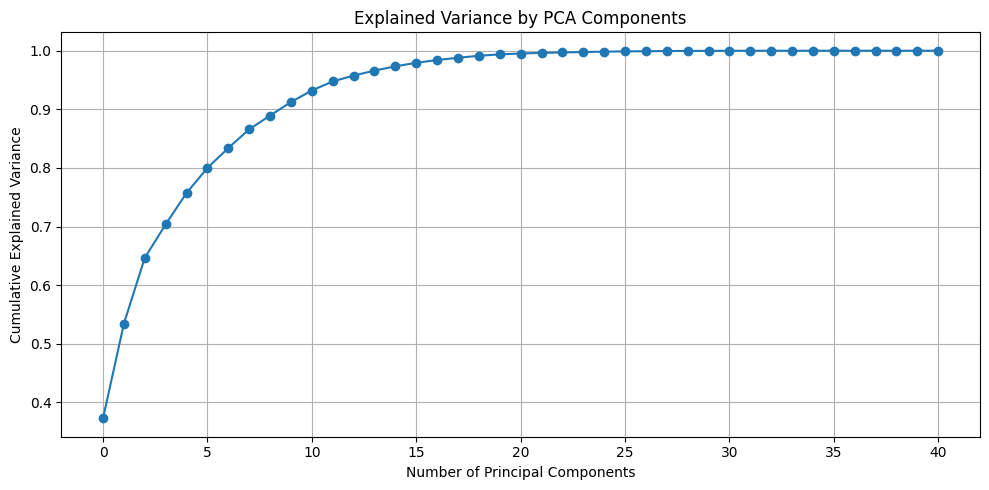

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming normalized_features is my normalized feature dataframe

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(normalized_features)

# Get explained variance
explained_var = pca.explained_variance_ratio_ * 100
cumulative_var = np.cumsum(pca.explained_variance_ratio_) * 100

# Print until cumulative variance reaches 95%
for i, (var, cum_var) in enumerate(zip(explained_var, cumulative_var)):
    print(f"PC{i+1}: {var:.2f}% variance explained, Cumulative: {cum_var:.2f}%")
    if cum_var >= 95:
        break

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.tight_layout()
plt.show()


**OBSERVATION**:

-The first 3 PCs alone explain approximately 65% of the total variance, indicating that a majority of the information in the dataset can be captured using just a few components.

-95.75% of the total variance is explained by the first 13 components, suggesting that the original 45 dimensional feature space can be reduced to approx. 13 dimensions with minimal information loss.
-



---



**Scree Plot** (to observe the optimal number of components)

Kneed Algorithms is applied to pick the maximum curavture which occurs in case of elbow.

In [ ]:
!pip install kneed


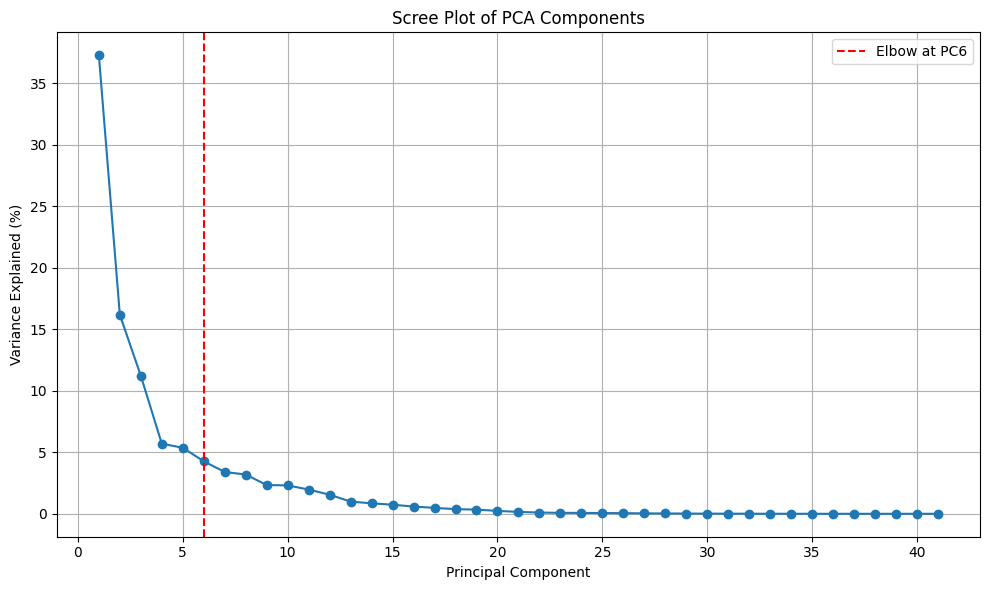

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kneed import KneeLocator

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(normalized_features)

# Explained variance
explained_var = pca.explained_variance_ratio_ * 100
cumulative_var = np.cumsum(pca.explained_variance_ratio_) * 100

# Determine elbow (knee) point
knee = KneeLocator(
    x=range(1, len(explained_var) + 1),
    y=explained_var,
    curve='convex',
    direction='decreasing'
)
elbow_point = knee.knee

# Plot Scree Plot with Elbow Highlighted
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow at PC{elbow_point}')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**OBSERVATION:**

Scree plot shows the explained variance for each principal component, with an elbow at PC6, indicating the point beyond which additional components contribute marginally.

-This helps determine the optimal number of components to retain for effective dimensionality reduction.

**PCA Loadings for 13 componnets**

*The first 13 components explaining approximately 95% of the total variance were selected for further analysis.*

In [ ]:
#Compute loadings for components covering 95% variance
num_components = np.argmax(cumulative_var >= 95) + 1  # +1 because index starts at 0
loadings = pca.components_.T  # Transpose to get features x components

# Create loadings dataframe
feature_names = normalized_features.columns
loadings_subset = pd.DataFrame(loadings[:, :num_components],
                                index=feature_names,
                                columns=[f'PC{i+1}' for i in range(num_components)])

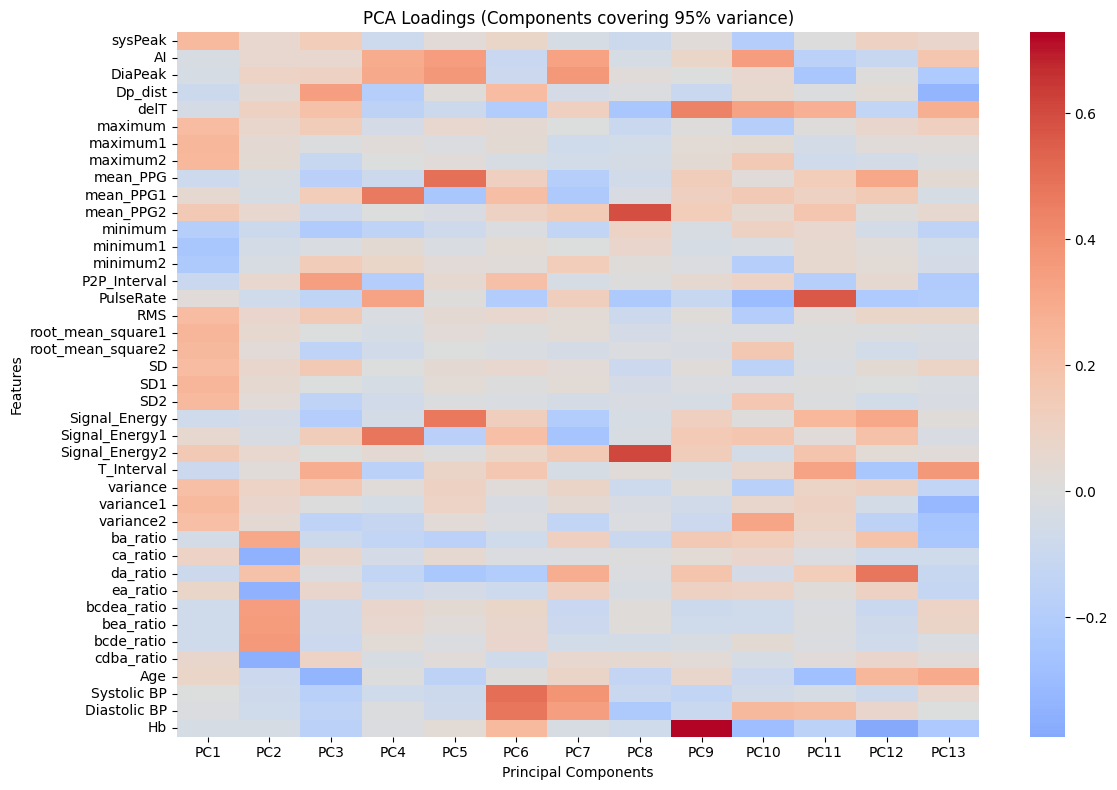

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_subset, cmap='coolwarm', center=0, annot=False)
plt.title('PCA Loadings (Components covering 95% variance)')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
for pc in loadings_subset.columns:
    print(f'\nTop features for {pc}:')
    print(loadings_subset[pc].abs().sort_values(ascending=False).head(5))



Top features for PC1:
SD1                  0.251419
root_mean_square1    0.251336
maximum1             0.248036
minimum1             0.247317
maximum2             0.239846
Name: PC1, dtype: float64

Top features for PC2:
cdba_ratio     0.357630
bcde_ratio     0.357630
bea_ratio      0.354671
bcdea_ratio    0.351607
ca_ratio       0.347871
Name: PC2, dtype: float64

Top features for PC3:
Dp_dist         0.344044
P2P_Interval    0.343855
Age             0.333690
T_Interval      0.290705
minimum         0.210976
Name: PC3, dtype: float64

Top features for PC4:
Signal_Energy1    0.482711
mean_PPG1         0.468113
PulseRate         0.330793
DiaPeak           0.303368
AI                0.293461
Name: PC4, dtype: float64

Top features for PC5:
mean_PPG         0.496441
Signal_Energy    0.473282
DiaPeak          0.366109
AI               0.350468
mean_PPG1        0.243256
Name: PC5, dtype: float64

Top features for PC6:
Systolic BP     0.504123
Diastolic BP    0.483843
Hb              0.2295

**OBSERVATION**:

-In early PCs, many features contribute moderately rather than a few dominating, indicating distributed variance across features.

-PC1 is influenced most by features like maximum2 and minimum1, indicating it captures general signal amplitude variability.

-PC2 is mainly driven by vascular stiffness ratios (cdba_ratio, bcde_ratio, bea_ratio, bcdea_ratio, ca_ratio), highlighting their strong role in the second principal axis.

**Projection of Data along 2 PCs**

-The 2D scatter plot of the first two PCs was created to visualize the data distribution in a reduced dimensional space.

-By projecting the high-dimensional feature set onto PC1 and PC2, which together capture the largest share of variance, this plot helps identify patterns, trends, and potential outliers.

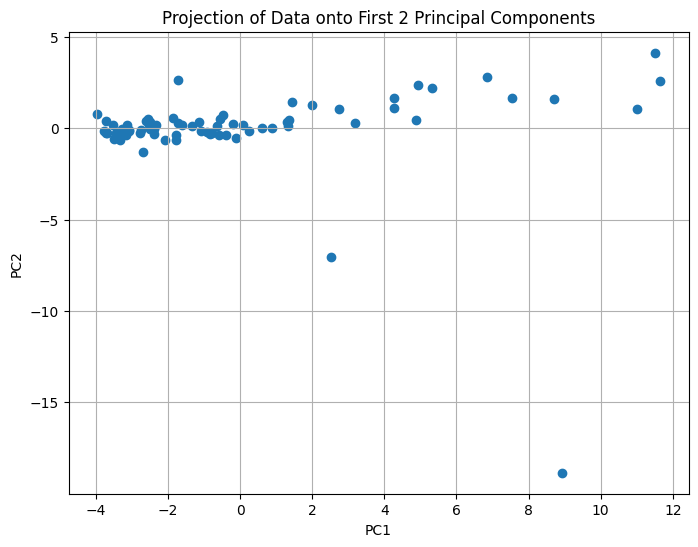

In [ ]:
#plot first two PCs
# Apply PCA with fixed n_components = 2
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(normalized_features)

# Scatter plot of samples in PC1 vs PC2 space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection of Data onto First 2 Principal Components')
plt.grid(True)
plt.show() #Eat dot represents one sample from my dataset


**Observation**

-Most data points are densely clustered in the region where PC1 is between -4 and 4, and PC2 is close to 0.

-This suggests that most of the variation in the data lies along PC1, while PC2 contributes relatively less.

-There is one clear outlier seen in PC space.

**Outlier detetcion, Investigation and Removal**

In [ ]:
# Outlier detection: samples far away in PC space
# Here: look for outliers based on PC2 extreme values
pc2_scores = X_pca[:, 1]   # Note: use X_pca directly (PC2 is column 1)

threshold = np.mean(pc2_scores) - 3*np.std(pc2_scores)
outliers_idx = np.where(pc2_scores < threshold)[0]

print(f"\nNumber of outliers detected (3-sigma rule on PC2): {len(outliers_idx)}")
print("Outlier sample indices:", outliers_idx)

# Show which features contribute most to PC2
pc2_loadings = loadings_subset['PC2']   # <-- fixed: use loadings_subset, not loadings
top_contributors = pc2_loadings.abs().sort_values(ascending=False)
print("\nTop contributing features to PC2 (which explains the outlier):")
print(top_contributors.head(10))

# Print exact feature values of outliers
print("\nFeature values of the first outlier:")
print(normalized_features.iloc[outliers_idx[0]])



Number of outliers detected (3-sigma rule on PC2): 1
Outlier sample indices: [66]

Top contributing features to PC2 (which explains the outlier):
cdba_ratio     0.357630
bcde_ratio     0.357630
bea_ratio      0.354671
bcdea_ratio    0.351607
ca_ratio       0.347871
ea_ratio       0.346238
ba_ratio       0.307137
da_ratio       0.199497
delT           0.096553
variance       0.093736
Name: PC2, dtype: float64

Feature values of the first outlier:
sysPeak              1.219604
AI                  -1.241739
DiaPeak             -2.046055
Dp_dist             -0.675339
delT                -0.320089
maximum              1.032512
maximum1             1.220685
maximum2             1.162606
mean_PPG            -1.249021
mean_PPG1            0.630735
mean_PPG2            0.169955
minimum             -0.415978
minimum1            -1.365344
minimum2            -1.199902
P2P_Interval        -0.882598
PulseRate            0.681476
RMS                  1.022126
root_mean_square1    1.325019
root_mean

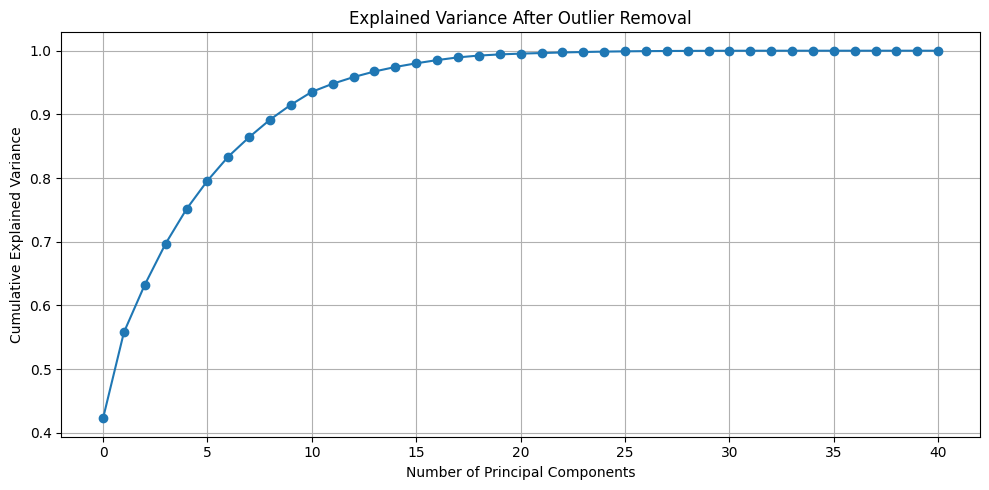

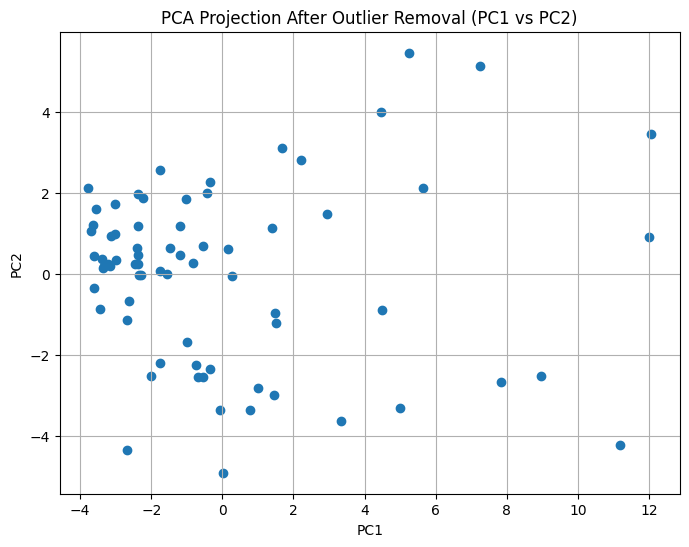

In [ ]:
# Remove outlier directly from existing normalized_features
normalized_features_clean = normalized_features.drop(index=66)

# Apply PCA again
pca_clean = PCA()
X_pca_clean = pca_clean.fit_transform(normalized_features_clean)

# Plot after outlier removal
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_clean.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance After Outlier Removal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Projection onto first 2 principal components
pca_2d_clean = PCA(n_components=2)
X_pca_2d_clean = pca_2d_clean.fit_transform(normalized_features_clean)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d_clean[:, 0], X_pca_2d_clean[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection After Outlier Removal (PC1 vs PC2)')
plt.grid(True)
plt.show()

**Explanation**:

The outlier is identified using the 3-sigma rule on PC2 scores and removed from the normalized_features DataFrame using its index (66) before reapplying PCA.

**Observation after Outlier Removal:**

-Removal of outlier improved variance concentration and clearer cluster seperation.



---



**Class Averaged PCA Scores**

To explore whether glucose levels (high vs. low) correspond to distinguishable patterns in the principal component space after dimensionality reduction.

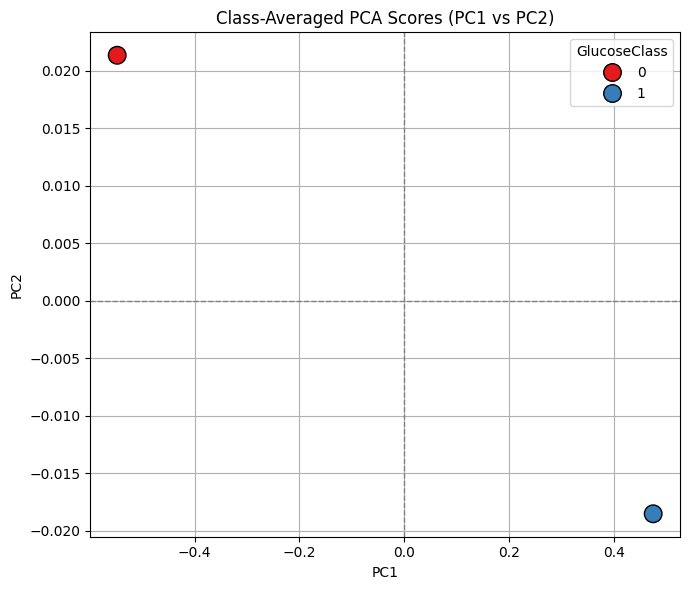

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Step 1: Get glucose target and remove outlier
target = df_numerical_clean['Glucose Level']
glucose_class_labels_clean = target.drop(index=66)

# Binarize using median threshold
median_threshold = glucose_class_labels_clean.median()
glucose_class_binary = (glucose_class_labels_clean >= median_threshold).astype(int)

# Step 2: Apply PCA to cleaned, normalized features
pca_2d_clean = PCA(n_components=2)
X_pca_2d_clean = pca_2d_clean.fit_transform(normalized_features_clean)

# Step 3: Create DataFrame with PCA scores and binary class
df_scores = pd.DataFrame({
    'PC1': X_pca_2d_clean[:, 0],
    'PC2': X_pca_2d_clean[:, 1],
    'GlucoseClass': glucose_class_binary.values
})

# Step 4: Compute average PC1 and PC2 per class
avg_scores = df_scores.groupby('GlucoseClass')[['PC1', 'PC2']].mean().reset_index()

# Step 5: Plot class-averaged PC scores
plt.figure(figsize=(7, 6))
sns.scatterplot(data=avg_scores, x='PC1', y='PC2', hue='GlucoseClass', palette='Set1', s=160, edgecolor='black')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Class-Averaged PCA Scores (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation**:

-The two glucose classes show clear separation along both PC1 and PC2 axes, indicating that the underlying features contribute differently to each class.

-PCA can capture discriminative variance relevant to glucose classification.

**Classification Task**

- Threshold for classification is set by taking mediam of the target column (Glucose values).

- Values above median are categorized as high and below as low. (2 class classification task)

In [ ]:
target=df_numerical_clean['Glucose Level']

# Drop index 66 from target to align with cleaned features
target_clean = target.drop(index=66)

# Create binary target from glucose using median threshold
threshold = target_clean.median()

binary_target = (target_clean >= threshold).astype(int)


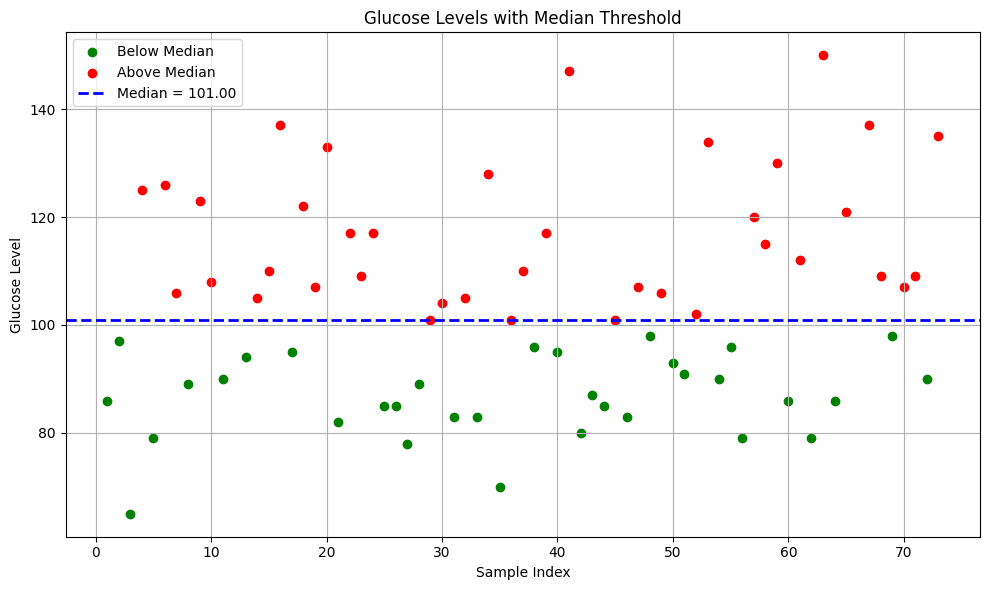

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plt.figure(figsize=(10,6))

# Below median (green dots)
plt.scatter(target_clean.index[target_clean < threshold],
            target_clean[target_clean < threshold],
            color='green', label='Below Median')

# Above median (red dots)
plt.scatter(target_clean.index[target_clean >= threshold],
            target_clean[target_clean >= threshold],
            color='red', label='Above Median')

# Plot median threshold line
plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=2, label=f'Median = {threshold:.2f}')

# Labels and title
plt.title('Glucose Levels with Median Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Glucose Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


It is observed that both classes ar enot properly balanced. Also, alot of data points are near median. So, it's a difficult classification task.



---



**Testing on Raw features (Without Dimensionality Reduction) - With all features**

-A RF classifier was trained on the normalized features to predict binary glucose classes.

-80/20 train-test split is used.

-The model's performance is evaluated using accuracy, a confusion matrix, and a classifican report.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Convert target into binary classes based on threshold
binary_target = (target_clean >= threshold).astype(int)

# Split into train and test sets (e.g. 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(normalized_features_clean, binary_target, test_size=0.2, random_state=42, stratify=binary_target)


# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

# Optional: Show confusion matrix & classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.53
Confusion Matrix:
 [[4 3]
 [4 4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.57      0.50      0.53         8

    accuracy                           0.53        15
   macro avg       0.54      0.54      0.53        15
weighted avg       0.54      0.53      0.53        15



**2. PCA with all features (PPG+Physiological)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize list to store accuracies
# accuracies = []

PCA Components Performance Analysis

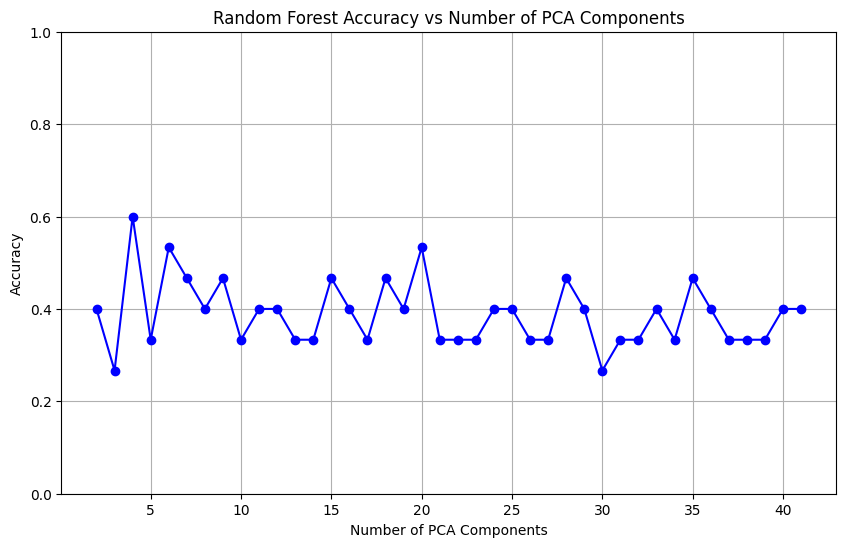

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Get total number of PCA components
total_components = X_pca_clean.shape[1]  # This gives full number of PCA components

# Initialize list to store accuracies
accuracies = []

# Loop over 1 to total_components
for n_components in range(2, total_components + 1):
    # Select first n_components PCA components
    X = X_pca_clean[:, :n_components]
    Y = binary_target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf_classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(2, total_components+1), accuracies, marker='o', linestyle='-', color='b')
plt.title('Random Forest Accuracy vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


**Observation**:

-No consistent improvement with more components. Instead, it fluctuates, indicating that adding more components does not necessarily enhance model performance.

-The peak accuracy (~0.60) appears around 6 PCA components.

**3. PCA on Feature Set excluding Hb**




In [ ]:
# Remove Hb from normalized_features_clean
features_Hb_removed = normalized_features_clean.drop(columns=['Hb'])

# Apply PCA again
pca_reduced = PCA()
X_pca_reduced = pca_reduced.fit_transform(features_Hb_removed)
# y already defined


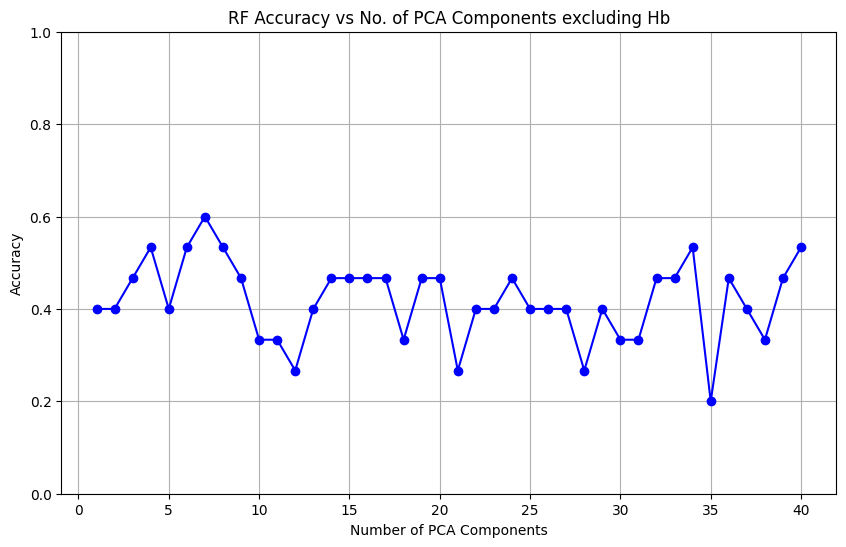

In [ ]:
# Get total number of PCA components
total_components = X_pca_reduced.shape[1]  # This gives full number of PCA components

# Initialize list to store accuracies
accuracies = []

# Loop over 2 to total_components
for n_components in range(1, total_components + 1):
    # Select first n_components PCA components
    X = X_pca_reduced[:, :n_components]
    Y = binary_target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf_classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(1, total_components+1), accuracies, marker='o', linestyle='-', color='b')
plt.title('RF Accuracy vs No. of PCA Components excluding Hb')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


-The peak accuracy (~0.60) appears around 6 PCA components.

**4. PCA excluding BP**

In [ ]:
# Remove BP from normalized_features_clean
features_BP_removed = normalized_features_clean.drop(columns=['Systolic BP', 'Diastolic BP'])

# Apply PCA again
pca_reduced = PCA()
X_pca_reduced = pca_reduced.fit_transform(features_Hb_removed)
# y already defined


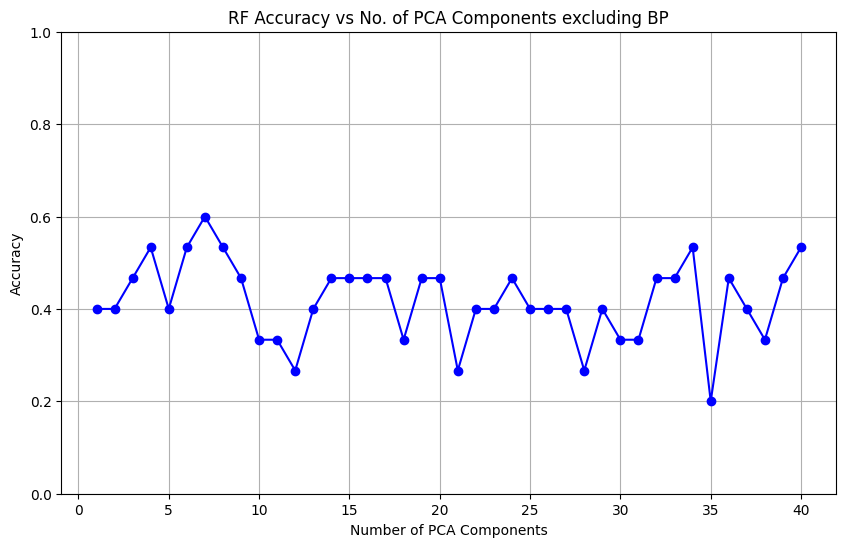

In [ ]:
# Get total number of PCA components
total_components = X_pca_reduced.shape[1]  # This gives full number of PCA components

# Initialize list to store accuracies
accuracies = []

# Loop over 2 to total_components
for n_components in range(1, total_components + 1):
    # Select first n_components PCA components
    X = X_pca_reduced[:, :n_components]
    Y = binary_target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf_classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(1, total_components+1), accuracies, marker='o', linestyle='-', color='b')
plt.title('RF Accuracy vs No. of PCA Components excluding BP')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


-The peak accuracy (~0.60) appears around 6 PC components.

**5. PCA after dropping Physiological features**

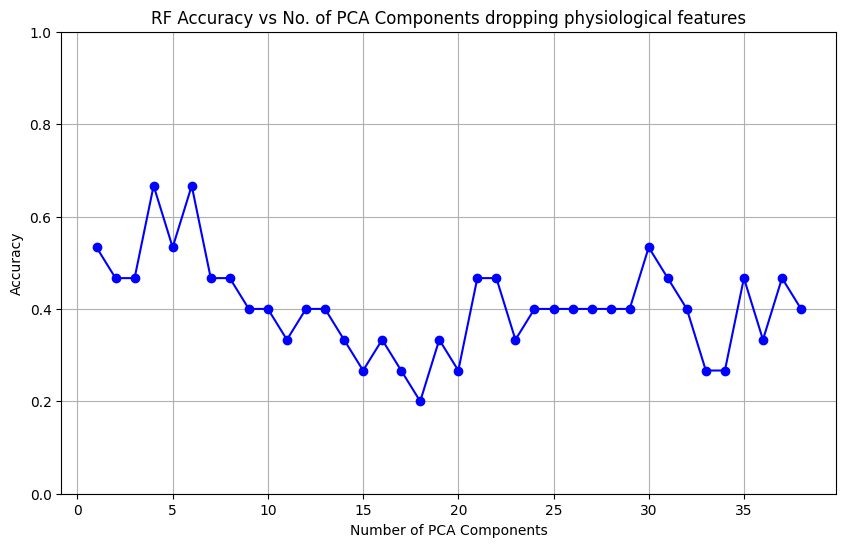

In [ ]:
# Remove Hb, Systolic BP, and Diastolic BP from normalized_features_clean
features_reduced = normalized_features_clean.drop(columns=['Hb', 'Systolic BP', 'Diastolic BP'])

# Apply PCA
pca = PCA()
X_pca_reduced = pca.fit_transform(features_reduced)

# Get total number of PCA components
total_components = X_pca_reduced.shape[1]  # This gives full number of PCA components

# Initialize list to store accuracies
accuracies = []

# Loop over 2 to total_components
for n_components in range(1, total_components + 1):
    # Select first n_components PCA components
    X = X_pca_reduced[:, :n_components]
    Y = binary_target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf_classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(1, total_components+1), accuracies, marker='o', linestyle='-', color='b')
plt.title('RF Accuracy vs No. of PCA Components dropping physiological features')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


-The peak accuracy (~0.66) appears around 4 and 6 PCA components.

**Evaluation of Model Performance after using 6 compoennts**

Classification Accuracy: 0.667


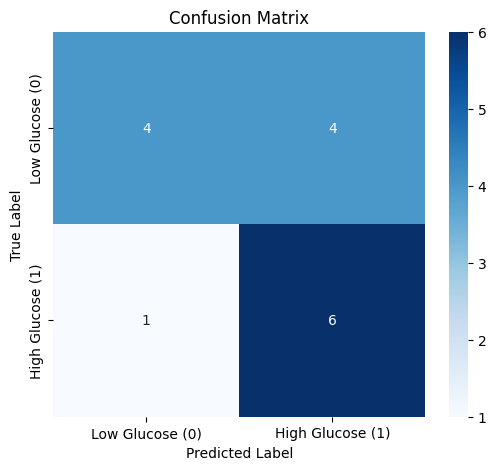


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.60      0.86      0.71         7

    accuracy                           0.67        15
   macro avg       0.70      0.68      0.66        15
weighted avg       0.71      0.67      0.66        15



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Use first 6 PCA components
X =  X_pca_reduced[:, :6]
Y = binary_target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {acc:.3f}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Glucose (0)', 'High Glucose (1)'], yticklabels=['Low Glucose (0)', 'High Glucose (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))



**2nd Dimensionality reduction Technique : LDA**

-LDA is a supervised dimensionality reduction technique.

-Unlike PCA (which maximizes variance regardless of class), LDA maximizes class separability and finds axes that best separate the classes based on the label information.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Assuming normalized_features is your feature set
X = normalized_features_clean
y = binary_target

# Apply LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

# Check shape
print("LDA-transformed shape:", X_lda.shape)


LDA-transformed shape: (71, 1)


-LDA-transformed shape (71, 1) shows there are 71 samples, each represented by 1 discriminative feature.

-Only 1 LDA component is generated because LDA can produce (number of classes - 1) components, and there are 2 classes in the dataset.

**Droping Physiological features one by one and checking accuracy through LDA+RF**

In [ ]:
X = normalized_features_clean.copy()

X_reduced= X

#-----------------Seperte Analysis------------------ LDA PERFORMANCE ANALYSIS WITH DIFFERENT FEATURES SETS

#X_reduced = X.drop(columns=['Hb'])  #Feature Set 01
#X_reduced = X.drop(columns=['Systolic BP']) -- Feature set 2
#X_reduced = X.drop(columns=['Diastolic BP'])--- Feature Set 03

#X_reduced = X.drop(columns=['Hb','Systolic BP','Diastolic BP'])  #Feature Set 01


#Apply LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_reduced, y)

#Check shape
print("LDA-transformed shape:", X_lda.shape)


LDA-transformed shape: (71, 1)


Classification Accuracy: 0.867


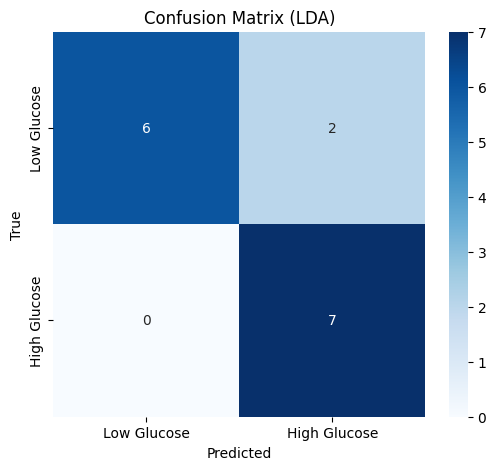


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.78      1.00      0.88         7

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15



In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

# Train RandomForest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {acc:.3f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Glucose', 'High Glucose'], yticklabels=['Low Glucose', 'High Glucose'])
plt.title('Confusion Matrix (LDA)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


**Observation:**

-The model achieved a high classification accuracy of 86.7%, indicating strong overall performance. (With all PPG & physiological features added)

-The High Glucose class was perfectly classified (recall = 1.00), while the Low Glucose class had minor misclassification (2 out of 8).

-Both classes show high F1-scores (0.86 and 0.88), reflecting a good balance between precision and recall.

**Grid Search with Stratified K Fold Cross Validation and ROC Curve Analysis**

Explanation:

-This step performs hyperparameter tuning for the RF classifier using GridSearchCV, which tests multiple combinations of parameters and selects the best set based on 5-fold cross-validated accuracy.

-It ensures the model is optimized for best performance, avoids overfitting, and uses stratified folds to maintain class balance during validation which is crucial for small datasets like my dataset.

Cross-Validated ROC AUC: 0.839


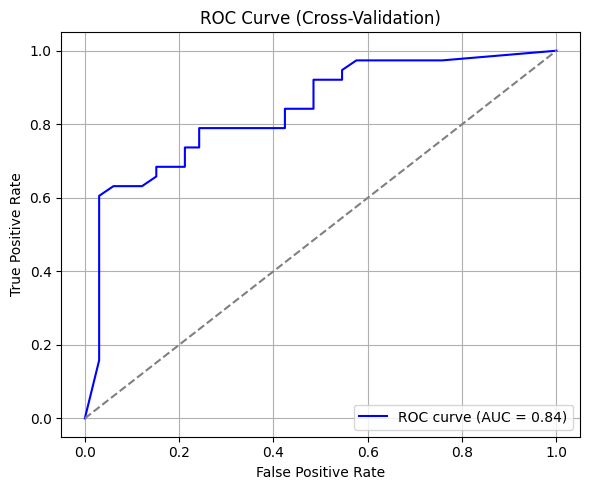

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Use the best hyperparameters to build a new RandomForestClassifier
best_rf = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42
)

# Get cross-validated predicted probabilities
# Note: cross_val_predict refits internally, so it's safe to use X, y again
y_proba_cv = cross_val_predict(
    best_rf, X, y,
    cv=5,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y, y_proba_cv)
print(f"Cross-Validated ROC AUC: {roc_auc:.3f}")

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Cross-Validation)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation:**

-The cross-validated AUC score is 0.839, indicating strong overall discriminative ability of the model.

-The ROC curve shows a steep rise toward the top-left corner, suggesting a good balance between sensitivity and specificity.

-This confirms that the LDA-transformed features, when used with a tuned Random Forest classifier, effectively distinguish between the glucose classes.

**CONCLUSION**

Using LDA with all features, the model achieved an AUC of 0.84 after cross-validation, indicating that physiological parameters particularly BP and Hb, play a vital role in glucose estimation. While individual correlations were weak, combined feature interactions proved effective. These findings highlight the potential of integrating physiological features in non-invasive glucose prediction.